In [200]:
import pandas as pd
import numpy as np
from scipy import stats


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
# import shap #  Cannot install on Python version 3.13.0; only versions >=3.9,<3.13 are supported.

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import joblib

### Read data set with UQS and CQMs

In [201]:

full_dataset_df = pd.read_csv('C:\\Users\\admin\\Desktop\\VGGFace2-200k-all.csv', sep=';')
train_set_df = pd.read_csv('VGGFace200k-random-state-36-train_set-only-filenames.csv', sep=';')
test_set_df = pd.read_csv('VGGFace200k-random-state-36-test_set-only-filenames.csv', sep=';')

# raw_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\LFW_scores.csv', sep=';')
# raw_copy_df = raw_df

# specific_dataset_df = pd.read_csv("C:\\Users\\admin\\source\\repos\\HelperScripts\\output_files\\VGGFace-200k-431-502.csv", sep=';')
# specific_dataset_df = pd.read_csv("VGGFace200k-random-state-36-test_set-only-filenames.csv", sep=';')

C:\Users\admin\AppData\Local\Temp\ipykernel_21212\3381239425.py:1: DtypeWarning: Columns (15,43) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset_df = pd.read_csv('C:\\Users\\admin\\Desktop\\VGGFace2-200k-all.csv', sep=';')


In [202]:
# specific_dataset_df.head()

### Inspect data

In [203]:
#train_df.columns

In [204]:
full_dataset_df.describe()

,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,CompressionArtifacts,...,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
count,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,195788.000000,195788.000000,197684.000000,197684.000000,197684.000000,...,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,0.0
mean,21.231196,80.664214,0.411592,0.262675,0.022222,0.211277,0.000570,6.779410,39.379429,0.838543,...,99.949283,99.952181,49.640062,47.061239,86.040292,95.182974,95.729143,46.441513,91.646405,NaN
std,3.933268,74.322003,0.218670,0.116430,0.016821,0.209541,0.008520,0.629621,18.780816,0.076957,...,2.101427,2.008245,33.027875,23.085901,20.928868,10.167331,10.403484,28.569081,24.834834,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,18.226044,28.511613,0.242798,0.176984,0.010652,0.059145,0.000000,6.488656,42.000000,0.795383,...,100.000000,100.000000,16.000000,31.000000,82.000000,95.000000,96.000000,19.000000,100.000000,NaN
50%,21.227950,61.484994,0.427597,0.252320,0.018125,0.133240,0.000000,6.900752,47.000000,0.858716,...,100.000000,100.000000,55.000000,49.000000,96.000000,98.000000,99.000000,41.000000,100.000000,NaN
75%,24.228010,110.766834,0.590830,0.336969,0.028969,0.296119,0.000000,7.209606,47.000000,0.895513,...,100.000000,100.000000,80.000000,64.000000,99.000000,100.000000,100.000000,72.000000,100.000000,NaN
max,35.189240,2056.000000,1.000000,0.868540,0.189381,1.000000,0.660669,7.960028,50.000000,0.997724,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,NaN


In [205]:
full_dataset_df.dtypes

Filename                               object
UnifiedQualityScore                   float64
BackgroundUniformity                  float64
IlluminationUniformity                float64
LuminanceMean                         float64
LuminanceVariance                     float64
UnderExposurePrevention               float64
OverExposurePrevention                float64
DynamicRange                          float64
Sharpness                               int64
CompressionArtifacts                  float64
NaturalColour                         float64
SingleFacePresent                     float64
EyesOpen                              float64
MouthClosed                           float64
EyesVisible                            object
MouthOcclusionPrevention              float64
FaceOcclusionPrevention               float64
InterEyeDistance                      float64
HeadSize                              float64
LeftwardCropOfTheFaceImage            float64
RightwardCropOfTheFaceImage       

In [206]:
# non_float_cells = train_df[train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]

# print(non_float_cells["EyesVisible"])

# OLD:
# # Remove rows where EyesVisible measure computation has failed 
# train_df = train_df[~train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]

def convert_nanind_to_0(value):
    if value == '-nan(ind)':
        return 0
    else:
        return value

# Set EyesVisible.scalar score to the lowest value of 0
full_dataset_df['EyesVisible.scalar'] = full_dataset_df['EyesVisible.scalar'].apply(lambda x: convert_nanind_to_0(x))
full_dataset_df['EyesVisible.scalar'] = full_dataset_df['EyesVisible.scalar'].astype(int)


# #also do it for the file to predict on
# test_what_we_remove = specific_dataset_df[specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]
# test_missing = test_what_we_remove[test_what_we_remove['Filename'].apply(lambda x: '45-0252_03' in x)]
# print(test_what_we_remove['Filename'])
# print(test_missing)
# print(len(test_what_we_remove))
# specific_dataset_df = specific_dataset_df[~specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]



In [207]:
# test_missing

In [208]:
# What is z-score exactly again?
#stats.zscore(train_df['MarginBelowOfTheFaceImage']).sort_values().tail(10)

In [209]:
pd.DataFrame(full_dataset_df.isnull().sum().sort_values(ascending=False))

,0
Unnamed: 57,197684
UnderExposurePrevention,1896
OverExposurePrevention,1896
InterEyeDistance,167
BackgroundUniformity,0
UnifiedQualityScore,0
LuminanceVariance,0
LuminanceMean,0
DynamicRange,0
Filename,0


In [210]:
# print(train_df['EyesVisible.scalar'].unique())
# train_df['EyesVisible.scalar'] = train_df['EyesVisible.scalar'].astype(str).astype(int)

# print(train_df['EyesVisible.scalar'].unique())
# Unique can help identify nan values 
#UnderExposurePrevention.scalar does not have nan but has -1. Maybe same with OverExposurePrevention, check.
# Use .fillna to fill nan values

In [211]:
#specific correlations between two CQMs
#train_df['MouthClosed'].corr(train_df['ExpressionNeutrality'])

## Choose to work with native or scalar scores and measures

In [212]:
# Save dataframe with filenames before dropping columns
test_set_filenames_df = pd.DataFrame(data=test_set_df["Filename"])



# specific_dataset_filenames_df = pd.DataFrame(data=specific_dataset_df["Filename"])



In [213]:
# Predict scalar UQS based on scalar CQMs
columns_to_drop = ['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
       'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
       'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
       'Sharpness', 'CompressionArtifacts', 'NaturalColour',
       'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
       'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
       'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
       'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
       'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
       'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57']


# Also drop CQMs that are not in landmarked region
# columns_to_drop.append(['BackgroundUniformity.scalar', 'SingleFacePresent.scalar',
#        'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar',  'NoHeadCoverings.scalar'])

In [214]:
ablation_name = "All"
ablation_columns_to_drop = [
]



# ablation_name = "Top-24"
# ablation_columns_to_drop = [
#     'MarginAboveOfTheFaceImage.scalar',
#     'BackgroundUniformity.scalar',
#     'ExpressionNeutrality.scalar'
# ]




# ablation_name = "Top-20"
# ablation_columns_to_drop = [
#     'HeadSize.scalar',
#     'CompressionArtifacts.scalar',
#     'RightwardCropOfTheFaceImage.scalar',
#     'LeftwardCropOfTheFaceImage.scalar',
#     'MarginAboveOfTheFaceImage.scalar',
#     'BackgroundUniformity.scalar',
#     'ExpressionNeutrality.scalar',
# ]




# ablation_name = "Top-15"
# ablation_columns_to_drop = [
#     'MouthClosed.scalar',
#     'OverExposurePrevention.scalar',
#     'NaturalColour.scalar',
#     'MarginBelowOfTheFaceImage.scalar',
#     'Sharpness.scalar',
#     'HeadSize.scalar',
#     'CompressionArtifacts.scalar',
#     'RightwardCropOfTheFaceImage.scalar',
#     'LeftwardCropOfTheFaceImage.scalar',
#     'MarginAboveOfTheFaceImage.scalar',
#     'BackgroundUniformity.scalar',
#     'ExpressionNeutrality.scalar'
# ]



# ablation_name = "Top-10"
# ablation_columns_to_drop = [
#     'IlluminationUniformity.scalar',
#     'UnderExposurePrevention.scalar',
#     'NoHeadCoverings.scalar',
#     'LuminanceVariance.scalar',
#     'SingleFacePresent.scalar',
#     'MouthClosed.scalar',
#     'OverExposurePrevention.scalar',
#     'NaturalColour.scalar',
#     'MarginBelowOfTheFaceImage.scalar',
#     'Sharpness.scalar',
#     'HeadSize.scalar',
#     'CompressionArtifacts.scalar',
#     'RightwardCropOfTheFaceImage.scalar',
#     'LeftwardCropOfTheFaceImage.scalar',
#     'MarginAboveOfTheFaceImage.scalar',
#     'BackgroundUniformity.scalar',
#     'ExpressionNeutrality.scalar'
# ]








columns_to_drop = columns_to_drop + ablation_columns_to_drop


# === CQMs ordered by pAUC from lowest to highest ===

# 'FaceOcclusionPrevention.scalar',
# 'EyesVisible.scalar',
# 'HeadPoseYaw.scalar',
# 'MouthOcclusionPrevention.scalar',
# 'HeadPosePitch.scalar',
# 'EyesOpen.scalar',
# 'HeadPoseRoll.scalar',
# 'InterEyeDistance.scalar',
# 'DynamicRange.scalar',
# 'LuminanceMean.scalar',
# 'IlluminationUniformity.scalar',
# 'UnderExposurePrevention.scalar',
# 'NoHeadCoverings.scalar',
# 'LuminanceVariance.scalar',
# 'SingleFacePresent.scalar',
# 'MouthClosed.scalar',
# 'OverExposurePrevention.scalar',
# 'NaturalColour.scalar',
# 'MarginBelowOfTheFaceImage.scalar',
# 'Sharpness.scalar',
# 'HeadSize.scalar',
# 'CompressionArtifacts.scalar',
# 'RightwardCropOfTheFaceImage.scalar',
# 'LeftwardCropOfTheFaceImage.scalar',
# 'MarginAboveOfTheFaceImage.scalar',
# 'BackgroundUniformity.scalar',
# 'ExpressionNeutrality.scalar'


In [215]:
full_dataset_df = full_dataset_df.drop(columns=columns_to_drop)
train_set_df = train_set_df.drop(columns=columns_to_drop)
test_set_df = test_set_df.drop(columns=columns_to_drop)
# raw_df = raw_df.drop(columns=columns_to_drop)
# specific_dataset_df = specific_dataset_df.drop(columns=columns_to_drop)

## Feature engineering

In [216]:
# train_df['MeanCropScore'] = (train_df['LeftwardCropOfTheFaceImage'] + train_df['RightwardCropOfTheFaceImage']) / 2
# train_df['MeanCropScore.scalar'] = (train_df['LeftwardCropOfTheFaceImage.scalar'] + train_df['RightwardCropOfTheFaceImage.scalar']) / 2

In [217]:
# train_df['MeanCropScore'].head(15)
# train_df['MeanCropScore.scalar'].head(15)

In [218]:
# train_df['MeanMarginScore'] = (train_df['MarginBelowOfTheFaceImage'] + train_df['MarginAboveOfTheFaceImage']) / 2
# train_df['MeanMarginScore.scalar'] = (train_df['MarginBelowOfTheFaceImage.scalar'] + train_df['MarginAboveOfTheFaceImage.scalar']) / 2


In [219]:
# train_df['MeanMarginScore'].head(15)
# train_df['MeanMarginScore.scalar'].head(15)

## Check correlations and drop some correlated features

<Axes: >

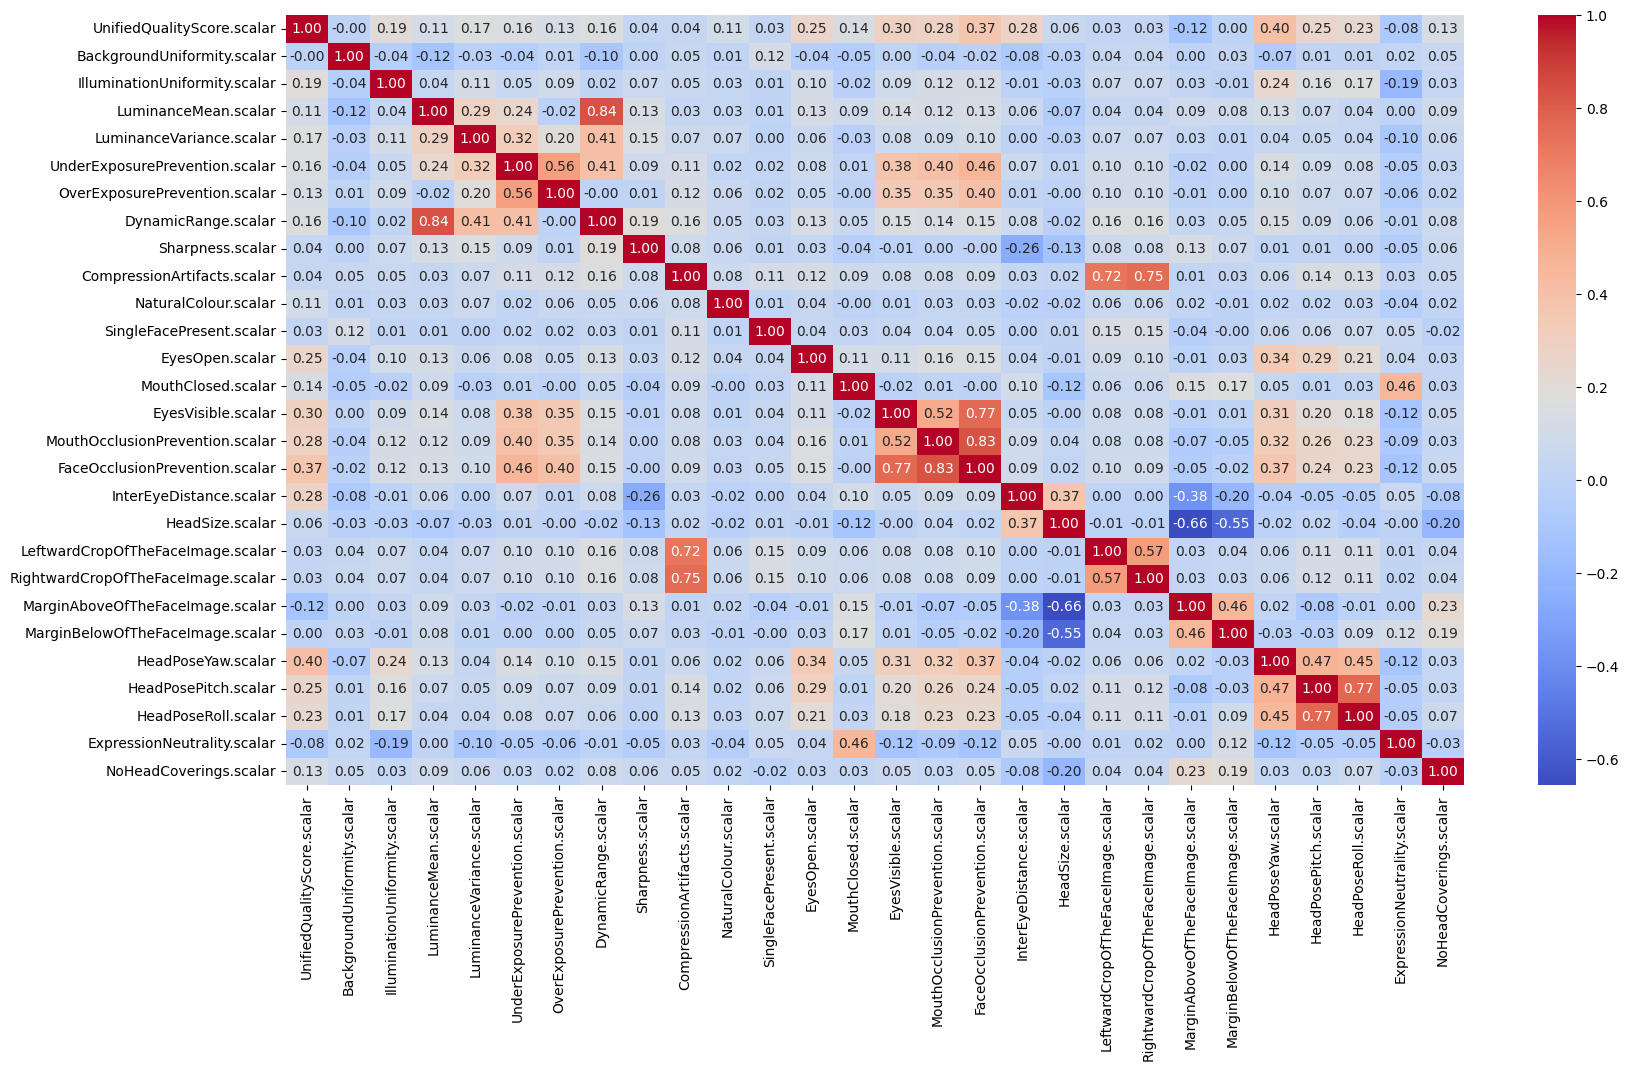

In [220]:
correlations = full_dataset_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

In [221]:
# FaceOcclusionPrevention or EyesVisible and MouthOcclusionPrevention?
# Remove ExpressionNeutrality or the ones it correlates with?
# train_df = train_df.drop(columns=['DynamicRange', 'HeadSize',
#                                   'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 
#                                   'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage'])
# train_df = train_df.drop(columns=['DynamicRange.scalar', 'HeadSize.scalar',
#                                   'LeftwardCropOfTheFaceImage.scalar', 'RightwardCropOfTheFaceImage.scalar', 
#                                   'MarginAboveOfTheFaceImage.scalar', 'MarginBelowOfTheFaceImage.scalar'])

<Axes: >

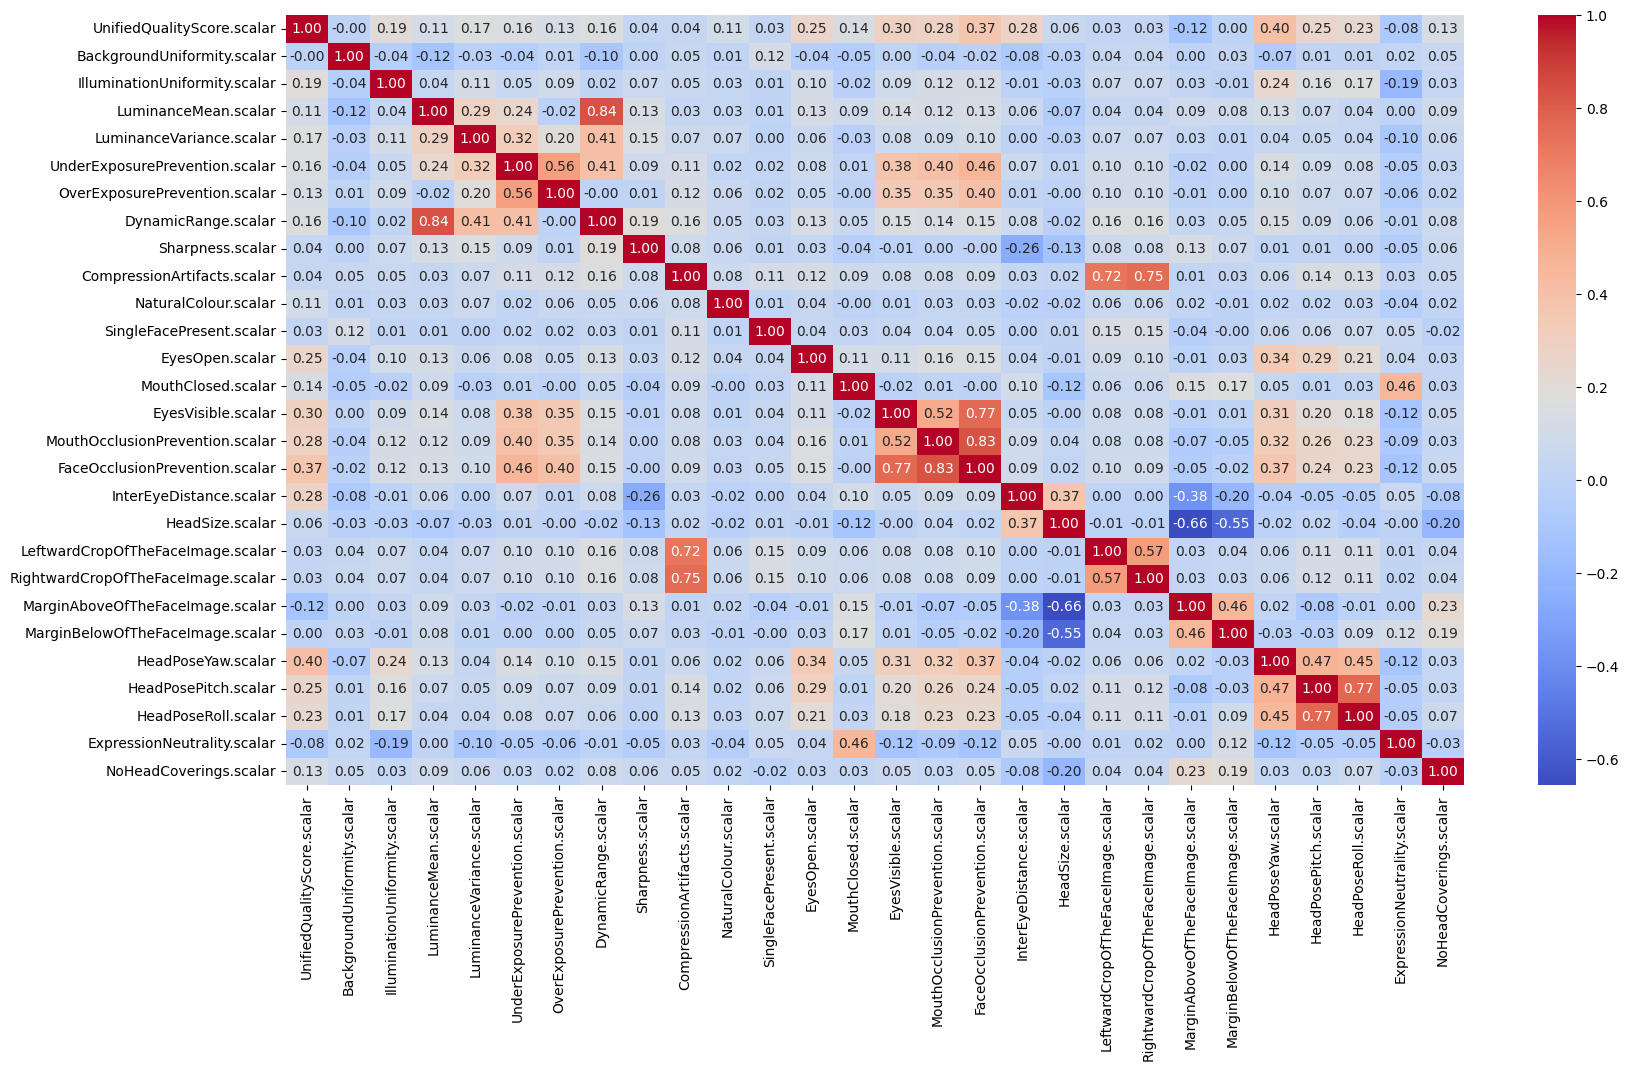

In [222]:
corr_after_drop = full_dataset_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(corr_after_drop, annot=True, cmap='coolwarm', fmt=".2f")

## UQS histogram

<Axes: xlabel='UnifiedQualityScore.scalar', ylabel='Count'>

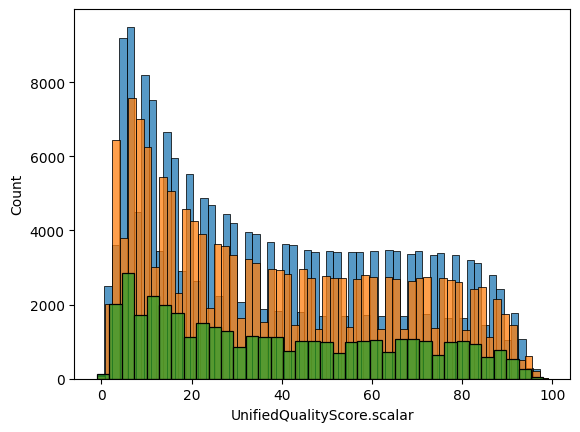

In [223]:
sns.histplot(
    full_dataset_df,
    x=full_dataset_df['UnifiedQualityScore.scalar']
)

sns.histplot(
    train_set_df,
    x=train_set_df['UnifiedQualityScore.scalar']
)


sns.histplot(
    test_set_df,
    x=test_set_df['UnifiedQualityScore.scalar']
)

In [224]:
# Consider logarithmic on non-scalar scores, so UnifiedQualityScore for example 
# train_df['UnifiedQualityScore_Log'] = np.log1p(train_df['UnifiedQualityScore'])

# Split training data into high quality and low quality classes

15000 images with a UQS higher than or equal to 80 are randomly chosen and used as the high quality images.
15000 images with a UQS greater than or equal to 0 and lower than or equal to 20 are randomly chosen and used as the low quality images.

In [225]:
train_set_df["UnifiedQualityScore.scalar"].describe()

count    158180.000000
mean         38.506398
std          26.999046
min          -1.000000
25%          14.000000
50%          34.000000
75%          61.000000
max          99.000000
Name: UnifiedQualityScore.scalar, dtype: float64

In [226]:
print(train_set_df["UnifiedQualityScore.scalar"].quantile(0.9))
print(train_set_df["UnifiedQualityScore.scalar"].quantile(0.1))

79.0
6.0


In [227]:
high_uqs_minimum = 80
low_uqs_minimum = 0
low_uqs_maximum = 20
high_quality_images_df = train_set_df[train_set_df["UnifiedQualityScore.scalar"].apply(lambda x: x >= high_uqs_minimum)]
low_quality_images_df = train_set_df[train_set_df["UnifiedQualityScore.scalar"].apply(lambda x: x >= low_uqs_minimum and x <= low_uqs_maximum)]

high_quality_images_df = pd.DataFrame(data=high_quality_images_df)
low_quality_images_df = pd.DataFrame(data=low_quality_images_df)

print(high_quality_images_df.describe())
print(low_quality_images_df.describe())

       UnifiedQualityScore.scalar  BackgroundUniformity.scalar  \
count                15234.000000                 15234.000000   
mean                    86.090456                    67.116581   
std                      4.252666                    23.695012   
min                     80.000000                    -1.000000   
25%                     82.000000                    52.000000   
50%                     86.000000                    72.000000   
75%                     89.000000                    87.000000   
max                     99.000000                   100.000000   

       IlluminationUniformity.scalar  LuminanceMean.scalar  \
count                   15234.000000          15234.000000   
mean                       78.146186             69.698438   
std                        13.562142             26.605188   
min                         0.000000              3.000000   
25%                        72.000000             50.000000   
50%                        82.000

In [228]:

high_quality_df = high_quality_images_df.sample(n=15000, random_state=36)
low_quality_df = low_quality_images_df.sample(n=15000, random_state=36)

high_quality_df['QualityClass'] = 1
low_quality_df['QualityClass'] = 0

combined_df = pd.concat([high_quality_df, low_quality_df], ignore_index=True)

print(combined_df)

       UnifiedQualityScore.scalar  BackgroundUniformity.scalar  \
0                              80                            8   
1                              88                           77   
2                              83                           76   
3                              90                           75   
4                              85                           84   
...                           ...                          ...   
29995                          10                           70   
29996                          16                           83   
29997                           3                           78   
29998                           4                           17   
29999                          15                           42   

       IlluminationUniformity.scalar  LuminanceMean.scalar  \
0                                 65                    83   
1                                 88                    99   
2                    

# Preprocessing

In [229]:
column_names = combined_df.select_dtypes(include=['int64', 'float64']).columns
column_names = column_names.drop(['UnifiedQualityScore.scalar', 'QualityClass'])

In [230]:
# Impute to fill missing values. Might not be necessary...
impute_and_scale_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [231]:
columns_transformed = ColumnTransformer(transformers=[
    ('num_p', impute_and_scale_pipeline, column_names)
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [232]:
preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', columns_transformed)
])

In [233]:
X = combined_df.drop(['UnifiedQualityScore.scalar', 'QualityClass'], axis=1)
y = combined_df['QualityClass']

test_set_X = test_set_df.drop(['UnifiedQualityScore.scalar'], axis=1)
# specific_dataset_X = specific_dataset_df.drop(['UnifiedQualityScore.scalar'], axis=1)

In [234]:
X_preprocessed = preprocess_pipeline.fit_transform(X)
test_set_X_preprocessed = preprocess_pipeline.fit_transform(test_set_X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=36)

In [235]:
y_test.sum() # there are 3027 high quality images vs. 2973 low quality images

np.int64(3027)

# Training

In [236]:
random_forest_classifier = RandomForestClassifier(random_state=36)

In [237]:
# there are more parameters that we can try to optimize
# Also, maybe consider using Optuna instead
# grid_parameters = {
#     'max_depth': [30],
#     'n_estimators': [1500],
#     'min_samples_split': [15]
# }
# max_depth: 15, n_estimators: 500, min_samples_split: 10
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.171904031005836) and 4.803700372340917
# {'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 300} gives np.float64(2.200307762445381) and 4.981448913268783
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.205441896749015) and 5.02581339484137 with a lot of columns removed
# Removing a lot of columns and FaceOcclusionPrevention as well makes it worse
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.1872035509314802) and 4.865764880207847 with some luminance stuff removed, headsize removed, margin averaged and crop averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 2.1734324686963307 and 4.820639260484793 with ['DynamicRange', 'HeadSize', 'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage']
#           removed and crop averaged and margin averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.560840972964996 and 310.4379027848181 with scalar version of ['DynamicRange', 'HeadSize', 'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage']
#           removed and crop averaged and margin averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.520939310617074 and 308.58041605776316 with everything kept (scalar)
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.32108712973725 and 298.34084529501126 using all native CQMs to predict scalar UQS. Takes a looong time to train though. 
 


In [238]:
# Create grid for RandomSearchCV

# For running multiple randomized search grids. So some can be very specific with only one possible set of parameters, and the model for that option will be saved,
# and the predicted UQS using that model will be saved
randomized_search_grids_dictionary = {} # Structure: Level 1 - Name of randomized search grid,    Level 2 - randomized search grid





# # === BROAD DEFAULT 1 ===
# # Results: we can get almost as good performance with 200 as 800, so choose 200 due to computing resource limitations and space limitations.
# n_estimators = [100, 200, 400, 600, 800]
# max_depth = [20, 30, 40, 50] # After BROAD 2 results: Low values are not good.
# max_features = ["sqrt", 6]
# min_samples_leaf = [1, 2, 4, 8, 15, 25] # After BROAD 2 results: High values are not good.
# min_samples_split = [2, 5, 10, 20, 40] # After BROAD 2 results: High values are not good
# bootstrap = [True, False] # After BROAD 2 results: seems to perform better without bootstrapping

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}

# randomized_search_grids_dictionary["BROAD_DEFAULT_1"] = randomized_search_grid






# # === SPECIFIC FINAL 1 ===
# # Results:
# n_estimators = [100] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [1]
# min_samples_split = [2]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_1"] = randomized_search_grid



# # === SPECIFIC FINAL 2 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [1]
# min_samples_split = [2]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_2"] = randomized_search_grid




# # === SPECIFIC FINAL 3 ===
# # Results:
# n_estimators = [100] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [2]
# min_samples_split = [4]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_3"] = randomized_search_grid




# # === SPECIFIC FINAL 4 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [2]
# min_samples_split = [4]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_4"] = randomized_search_grid




# # === SPECIFIC FINAL 5 ===
# # Results:
# n_estimators = [100] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [1]
# min_samples_split = [2]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_5"] = randomized_search_grid




# # === SPECIFIC FINAL 6 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [1]
# min_samples_split = [2]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_6"] = randomized_search_grid




# # === SPECIFIC FINAL 7 ===
# # Results:
# n_estimators = [100] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [2]
# min_samples_split = [4]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_7"] = randomized_search_grid



# # === SPECIFIC FINAL 8 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [2]
# min_samples_split = [4]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_8"] = randomized_search_grid




# # === SPECIFIC FINAL 9 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [4]
# min_samples_split = [8]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_9"] = randomized_search_grid




# # === SPECIFIC FINAL 10 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_10"] = randomized_search_grid




# === SPECIFIC FINAL 11 ===
# Results:
n_estimators = [200] 
max_depth = [30]
max_features = ["sqrt"]
min_samples_leaf = [16]
min_samples_split = [32]
bootstrap = [False]

randomized_search_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
randomized_search_grids_dictionary["SPECIFIC_FINAL_11"] = randomized_search_grid




# # === SPECIFIC FINAL 12 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = ["sqrt"]
# min_samples_leaf = [32]
# min_samples_split = [64]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_12"] = randomized_search_grid





# # === SPECIFIC FINAL 13 ===
# # Results:
# n_estimators = [200] 
# max_depth = [40]
# max_features = ["sqrt"]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_13"] = randomized_search_grid




# # === SPECIFIC FINAL 14 ===
# # Results:
# n_estimators = [200] 
# max_depth = [40]
# max_features = ["sqrt"]
# min_samples_leaf = [16]
# min_samples_split = [32]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_14"] = randomized_search_grid





# # === SPECIFIC FINAL 15 ===
# # Results:
# n_estimators = [200] 
# max_depth = [50]
# max_features = ["sqrt"]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_15"] = randomized_search_grid




# # === SPECIFIC FINAL 16 ===
# # Results:
# n_estimators = [200] 
# max_depth = [50]
# max_features = ["sqrt"]
# min_samples_leaf = [16]
# min_samples_split = [32]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_16"] = randomized_search_grid





# # === SPECIFIC FINAL 17 ===
# # Results:
# n_estimators = [200] 
# max_depth = [20]
# max_features = ["sqrt"]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_17"] = randomized_search_grid




# # === SPECIFIC FINAL 18 ===
# # Results:
# n_estimators = [200] 
# max_depth = [20]
# max_features = ["sqrt"]
# min_samples_leaf = [16]
# min_samples_split = [32]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_18"] = randomized_search_grid



# # === SPECIFIC FINAL 19 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_19"] = randomized_search_grid




# # === SPECIFIC FINAL 20 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [6]
# min_samples_leaf = [16]
# min_samples_split = [32]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_20"] = randomized_search_grid




# # === SPECIFIC FINAL 21 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [4]
# min_samples_leaf = [8]
# min_samples_split = [16]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_21"] = randomized_search_grid




# # === SPECIFIC FINAL 22 ===
# # Results:
# n_estimators = [200] 
# max_depth = [30]
# max_features = [4]
# min_samples_leaf = [16]
# min_samples_split = [32]
# bootstrap = [False]

# randomized_search_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf,
#                'min_samples_split': min_samples_split,
#                'bootstrap': bootstrap}
# randomized_search_grids_dictionary["SPECIFIC_FINAL_22"] = randomized_search_grid

In [239]:
def search_grid_and_save_model_and_results(randomized_search_grid, random_forest_classifier, X_train, y_train, cv_folds, model_name, ablation_name): 
    random_forest_cross_val = RandomizedSearchCV(estimator = random_forest_classifier, 
                                             param_distributions = randomized_search_grid,
                                             n_iter = 30,
                                             cv = cv_folds,
                                             verbose=3,
                                             random_state=36,
                                             n_jobs = -1)
    
    random_forest_cross_val.fit(X_train, y_train)
    
    results_of_randomized_search_cv = pd.DataFrame(random_forest_cross_val.cv_results_)
    results_of_randomized_search_cv.to_csv(f"./results_of_RandomizedSearchCVs/results_of_randomized_search_cv-RFC-{model_name}-{ablation_name}.csv", sep=';')

    model_filepath = f"./models/RFC_UQS_scalar_to_scalar_{model_name}-{ablation_name}_VGGFace-200k.pkl"
    # joblib.dump(random_forest_cross_val, model_filepath)

    return random_forest_cross_val

    

In [240]:
def predict_UQS_and_save(model, X_test_set, model_name, filenames_df, ablation_name):
    test_set_y_pred_proba = model.predict_proba(X_test_set)
    
    filenames_df_copy = filenames_df.copy(deep=True)
    filenames_df_copy["UQS"] = test_set_y_pred_proba[:, 1] * 100
    filenames_df_copy["UQS"] = filenames_df_copy["UQS"].apply(lambda x: round(x)).astype(int)

    filenames_df_copy[["Filename", "UQS"]].to_csv(f'./predicted_UQS_files/Predicted-UQS-RFC-{model_name}-{ablation_name}-Test_set-VGGFace200k.csv', index=False, sep=';')

In [241]:
def evaluate_model(model, X_test, y_test, model_name, ablation_name):
    score = model.score(X_test, y_test)
    score_df = pd.DataFrame(data=[score])
    score_df.columns = ["MeanAccuracy"]
    score_df.to_csv(f"RFC-evaluations/RFC-evaluation-{model_name}-{ablation_name}.csv", sep=';', index=False)
    

In [242]:
def plot_feature_importance(feature_importances_df, filepath_png, setting_name, ablation_name, threshold = None):
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(6)
    plt.subplots_adjust(bottom=0.4) # get labels to not be cut off
    ax.bar(feature_importances_df["feature"], feature_importances_df["feature_importance"])
    plt.xticks(rotation=45, ha='right')
    ax.set_ylabel('Feature importance')
    ax.set_title(f'Feature importances for RFC-{setting_name}-{ablation_name}')
    plt.savefig(filepath_png)
    plt.clf()


    


In [197]:
def save_feature_importances(model, feature_names, setting_name, ablation_name):
    feature_importances_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_, 'feature': feature_names})
    feature_importances_df = feature_importances_df.sort_values('feature_importance', ascending = False)
    filepath_csv = f"feature_importances/RFC-{ablation_name}/RFC-feature-importances-{setting_name}-{ablation_name}.csv"
    filepath_png = filepath_csv.replace("csv", "png")
    feature_importances_df.to_csv(filepath_csv, sep=';', index=False)
    plot_feature_importance(feature_importances_df, filepath_png, setting_name, ablation_name)
    

In [198]:
# Compute feature importances for existing saved models

# import os
# for root, dirs, files in os.walk(f"models\\RFC-{ablation_name}"):
#     for file in files:
#         model_path_current = os.path.join(root, file)
#         print(model_path_current)
#         model_current = joblib.load(model_path_current)
#         setting_and_ablation = model_path_current.split("scalar_to_scalar_")[1].split("_VGG")[0]
#         setting_name_current = setting_and_ablation.split('-')[0]
#         ablation_name_current = setting_and_ablation.split('-')[1]
#         if "Top" in ablation_name_current:
#             ablation_name_current += "-" + setting_and_ablation.split('-')[2] # if "Top-<something>".
#         print(setting_name_current)
#         print(ablation_name_current)
#         save_feature_importances(model_current.best_estimator_,
#                                  full_dataset_df.drop(columns=['UnifiedQualityScore.scalar']).columns,
#                                  setting_name_current,
#                                  ablation_name_current)


In [199]:
for setting_name, rs_grid in randomized_search_grids_dictionary.items():
    search_result = search_grid_and_save_model_and_results(rs_grid, random_forest_classifier, X_train, y_train, 5, setting_name, ablation_name)
    evaluate_model(search_result.best_estimator_, X_test, y_test, setting_name, ablation_name)
    predict_UQS_and_save(search_result.best_estimator_, test_set_X_preprocessed, setting_name, test_set_filenames_df, ablation_name)
    save_feature_importances(search_result.best_estimator_, full_dataset_df.drop(columns=['UnifiedQualityScore.scalar']).columns, setting_name, ablation_name)



c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


<Figure size 1200x600 with 0 Axes>

In [737]:
# random_forest_cross_val = RandomizedSearchCV(estimator = random_forest_classifier, 
#                                              param_distributions = randomized_search_grid,
#                                              n_iter = 100,
#                                              cv = 5,
#                                              verbose=3,
#                                              random_state=36,
#                                              n_jobs = -1)

In [738]:
# random_forest_cross_val.fit(X_train, y_train)
# # NOTE that X_test and y_test are not used here, so we can keep those for validation after training

In [739]:
# random_forest_cross_val.best_estimator_

In [740]:
# random_forest_cross_val.best_params_

In [741]:
# 1 - random_forest_cross_val.best_estimator_.oob_score_

In [742]:
# results_of_randomized_search_cv = pd.DataFrame(random_forest_cross_val.cv_results_)
# results_of_randomized_search_cv.to_csv("./results_of_RandomizedSearchCVs/results_of_randomized_search_cv_CLASSIFIER.csv", sep=';')

In [743]:
# results_of_randomized_search_cv

In [744]:
# model_filename = "./models/rfr_CLASSIFIER_UQS_scalar_to_scalar_RandomizedSearchCV_VGGFace-200k.pkl"

In [745]:

# joblib.dump(random_forest_cross_val, model_filename)

In [746]:
# load_saved_model_test = joblib.load(model_filename)

In [747]:
# y_pred_from_saved_model = load_saved_model_test.predict(X_test)

In [748]:
# X_test

In [749]:
# test_set_X_preprocessed

In [750]:
# specific_dataset_y_pred = load_saved_model_test.predict(test_set_X_preprocessed)
# specific_dataset_y_pred

In [751]:
# specific_dataset_y_pred_proba = load_saved_model_test.predict_proba(test_set_X_preprocessed)
# specific_dataset_y_pred_proba

In [752]:
# specific_dataset_filenames_df["PredictedUQS"] = specific_dataset_y_pred_proba[:, 1] * 100
# specific_dataset_filenames_df["PredictedUQS"] = specific_dataset_filenames_df["PredictedUQS"].apply(lambda x: round(x)).astype(int)
# specific_dataset_filenames_df

In [753]:
# specific_dataset_filenames_df.describe()

In [754]:
# specific_dataset_filenames_df.to_csv("predicted_UQS_files/Predicted-UQS-Test_set-RF-CLASSIFIER-Specific-14-All-Features-VGGFace200k.csv", sep=';', index=False)

In [755]:
# y_pred_from_saved_model

In [756]:
# y_specific_dataset_pred_from_saved_model

In [757]:
# specific_dataset_predictions_saved_model_df = pd.DataFrame(y_specific_dataset_pred_from_saved_model)
# filename_and_predicted_UQS_specific_dataset = pd.concat([filenames_specific_dataset, specific_dataset_predictions_saved_model_df], axis=1)
# filename_and_predicted_UQS_specific_dataset.to_csv('Predicted-UQS_Specific_Dataset.csv', index=False, sep=';')

In [758]:
# test_check = specific_dataset_df[45-252_03]
# test_check = specific_dataset_df[~specific_dataset_df['Filename'].apply(lambda x: '45-252_03' in x)]

In [759]:
# np.sqrt(-1 * random_forest_cross_val.best_score_)

In [760]:
# random_forest_cross_val.best_params_

In [761]:
# y_pred_random_forest = random_forest_cross_val.predict(X_test)

In [762]:
# y_pred_random_forest

In [763]:
# y_test

In [764]:
# mean_squared_error(y_test, y_pred_random_forest)

In [765]:
# mean_absolute_error(y_test, y_pred_random_forest)

In [766]:
# mean_absolute_percentage_error(y_test, y_pred_random_forest)

In [767]:
# predictions_for_raw_dataset_random_forest = random_forest_cross_val.predict(X_raw_preprocessed)

In [768]:
# predictions_raw_df = pd.DataFrame(predictions_for_raw_dataset_random_forest)
# filename_raw_df = raw_copy_df["Filename"]
# filename_and_predicted_UQS_Raw = pd.concat([filename_raw_df, predictions_raw_df], axis=1)
# filename_and_predicted_UQS_Raw.to_csv('Predicted-UQS_LFW-RandomizedSearchCV.csv', index=False, sep=';')

In [769]:
# predictions_test_set_df = pd.DataFrame(y_pred_random_forest)
# filename_and_predicted_UQS_Raw = pd.concat([filenames_test, predictions_test_set_df], axis=1)
# filename_and_predicted_UQS_Raw.to_csv('Predicted-UQS_TestSet-RandomizedSearchCV.csv', index=False, sep=';')

In [770]:
# random_forest_specific = RandomForestRegressor(n_estimators=1000, max_depth= 20, min_samples_split=20, random_state=13)

In [771]:
# model_test = random_forest_specific.fit(X_train, y_train)

In [772]:
without_uqs = combined_df.drop(columns=['UnifiedQualityScore.scalar', 'QualityClass'])
# without_uqs = train_df.drop(columns=['UnifiedQualityScore.scalar'])
# without_uqs = train_df.drop(columns=['UnifiedQualityScore'])

In [773]:
# y_pred_single = model_test.predict(X_test)

In [774]:
# y_pred_single

In [775]:
# y_test

In [776]:
# mean_squared_error(y_test, y_pred_single)

In [777]:
# mean_absolute_error(y_test, y_pred_single)

In [778]:
# mean_absolute_percentage_error(y_test, y_pred_single)

In [779]:
# TODO: Add link to where I found this.
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    fig = px.bar(
        feature_importance_df,
        text_auto = '.2f',
        labels = {'value': 'feature importance'},
        title = 'Feature importances'
    )

    fig.update_layout(showlegend = False)
    fig.show()

# plot_feature_importance(model_test, without_uqs.columns)

In [780]:
# print(len(without_uqs.columns))
# print(len(random_forest_cross_val.best_estimator_.feature_importances_))
# plot_feature_importance(random_forest_cross_val.best_estimator_, without_uqs.columns)

In [781]:
# permutation_importance = permutation_importance(random_forest_cross_val.best_estimator_, X_test, y_test)

In [782]:
# permutation_importance

In [783]:
# permutation_importance_df = pd.DataFrame(permutation_importance)

In [784]:
# permutation_importance_df.head()

In [785]:
# NOTE    ======== KEEP THIS =======

# rand_forest_best_estimator = random_forest_cross_val.best_estimator_
# importances = np.zeros((len(rand_forest_best_estimator.estimators_), rand_forest_best_estimator.n_features_in_))
# for i,tree in enumerate(rand_forest_best_estimator.estimators_):
#     importances[i] = tree.tree_.compute_feature_importances(normalize=False)
# np.mean(importances, axis=0)

In [786]:
# full_dataset_df.mean()

In [787]:
# TODO: What is this?? Doesn't seem to make sense...
# x_test_dataframe = pd.DataFrame(X_test)
# x_test_dataframe["prediction_mean"] = 48.490778
# predictions_mean = x_test_dataframe["prediction_mean"]
# x_test_dataframe.drop(columns=["prediction_mean"])
# predictions_mean.head()



In [788]:
# mean_squared_error(y_test, predictions_mean)

In [789]:
# mean_absolute_error(y_test, predictions_mean)

In [790]:
# mean_absolute_percentage_error(y_test, predictions_mean)

In [791]:
# root_mean_squared_error(y_test, predictions_mean)

## Scatter stuff

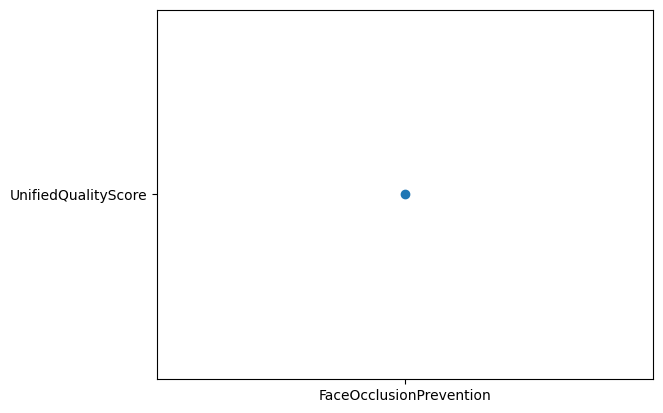

In [792]:
plt.scatter(x='FaceOcclusionPrevention', y='UnifiedQualityScore', data=full_dataset_df)

In [793]:
to_remove = full_dataset_df.query('FaceOcclusionPrevention > 0.7')

UndefinedVariableError: name 'FaceOcclusionPrevention' is not defined

In [ ]:
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]


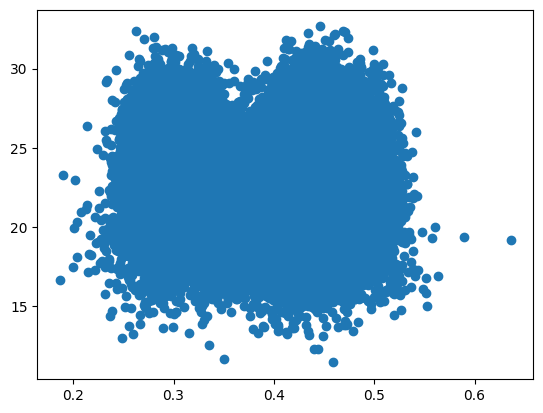

In [ ]:
plt.scatter(x='HeadSize', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('HeadSize > 0.575')
to_remove
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]


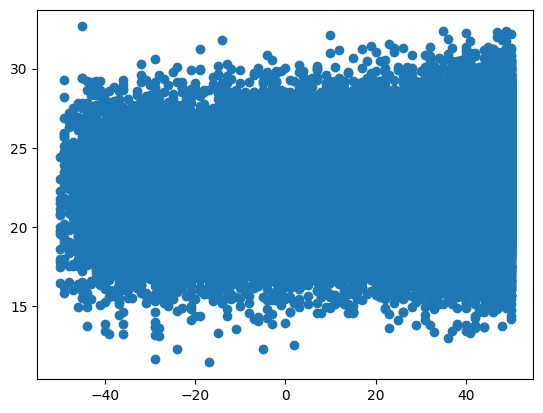

In [ ]:
plt.scatter(x='Sharpness', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('Sharpness < 0 and UnifiedQualityScore > 31')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]
to_remove = full_dataset_df.query('Sharpness < 0 and UnifiedQualityScore < 13')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]


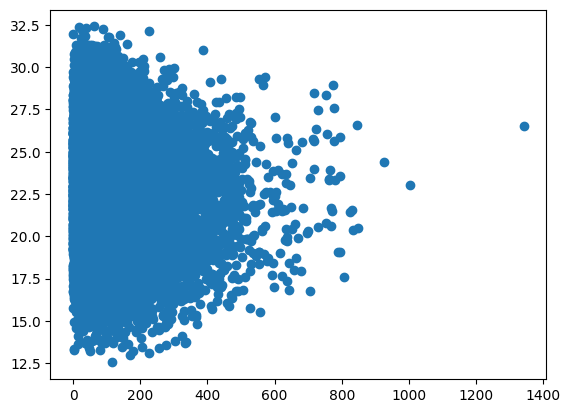

In [ ]:
plt.scatter(x='BackgroundUniformity', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('BackgroundUniformity > 900')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

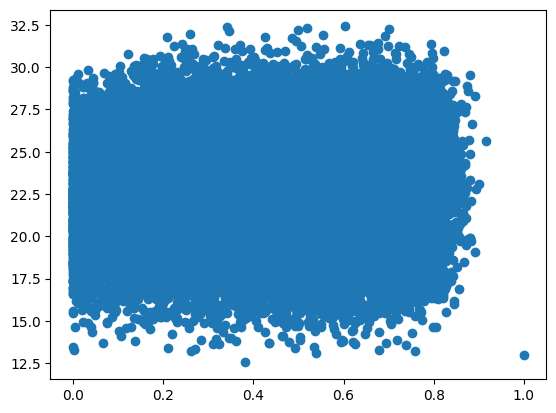

In [ ]:
plt.scatter(x='IlluminationUniformity', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('UnifiedQualityScore < 13')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

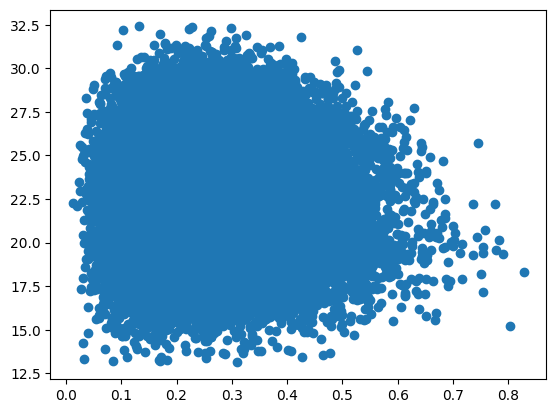

In [ ]:
plt.scatter(x='LuminanceMean', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('LuminanceMean > 0.8')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

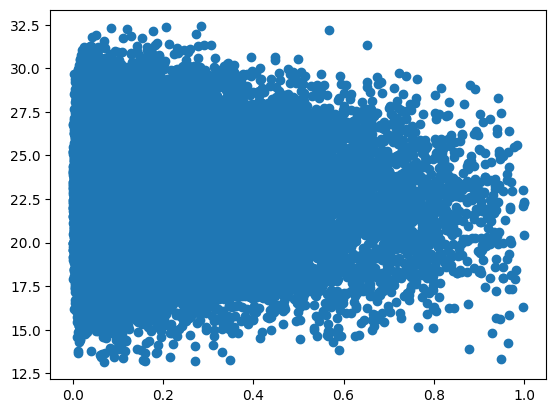

In [ ]:
plt.scatter(x='UnderExposurePrevention', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('UnderExposurePrevention > 0.85 and UnifiedQualityScore < 16')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]
to_remove = full_dataset_df.query('UnderExposurePrevention > 0.4 and UnifiedQualityScore > 31')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

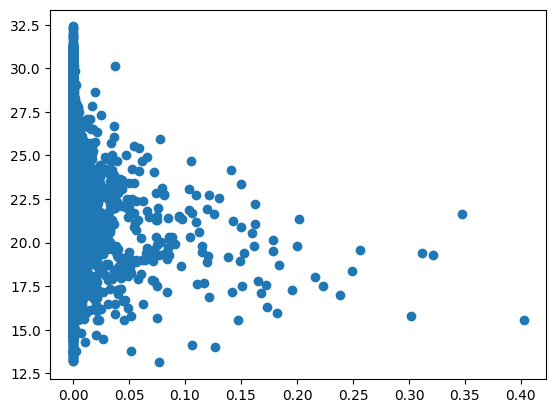

In [ ]:
plt.scatter(x='OverExposurePrevention', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('OverExposurePrevention > 0.275')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

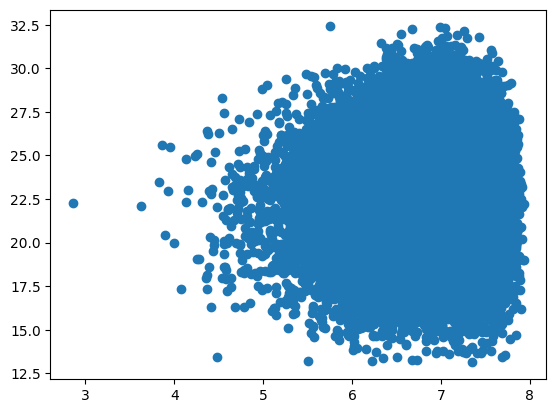

In [ ]:
plt.scatter(x='DynamicRange', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('DynamicRange < 3.5')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]
to_remove = full_dataset_df.query('DynamicRange < 5.75 and UnifiedQualityScore < 13.5')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]
to_remove = full_dataset_df.query('DynamicRange < 6 and UnifiedQualityScore > 32')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

In [ ]:
#plt.scatter(x='CompressionArtifacts', y='UnifiedQualityScore', data=train_df)
#to_remove = train_df.query('CompressionArtifacts < 0.75')
#train_df = train_df[train_df.index.isin(to_remove.index) == False]

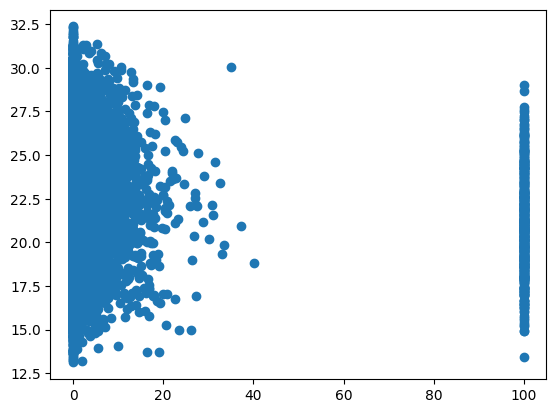

In [ ]:
plt.scatter(x='NaturalColour', y='UnifiedQualityScore', data=full_dataset_df)


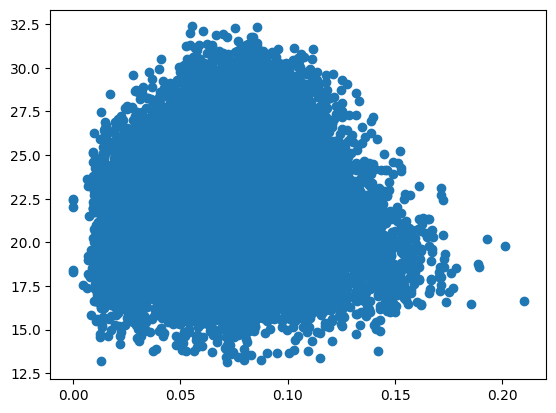

In [ ]:
plt.scatter(x='EyesOpen', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('EyesOpen > 0.17')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

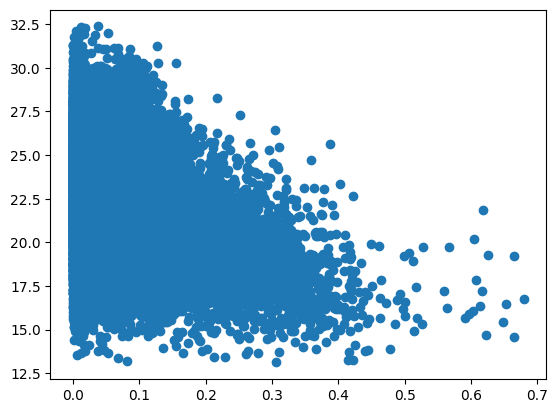

In [ ]:
plt.scatter(x='FaceOcclusionPrevention', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('FaceOcclusionPrevention > 0.5')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

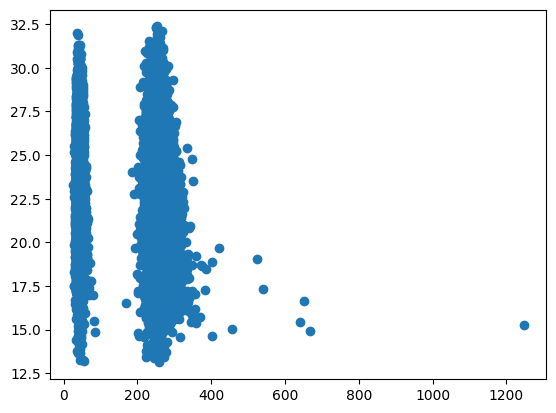

In [ ]:
plt.scatter(x='InterEyeDistance', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('InterEyeDistance > 400')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

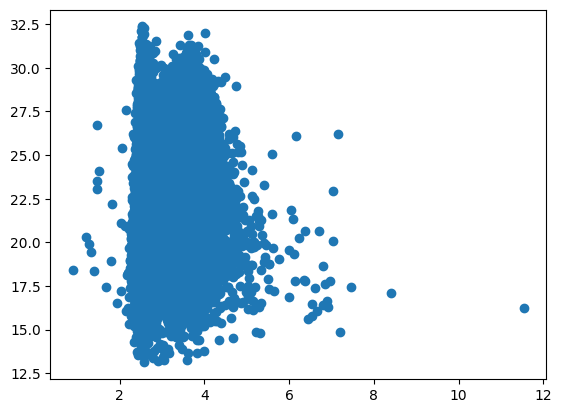

In [ ]:
plt.scatter(x='LeftwardCropOfTheFaceImage', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('LeftwardCropOfTheFaceImage > 5.5 or LeftwardCropOfTheFaceImage < 2')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

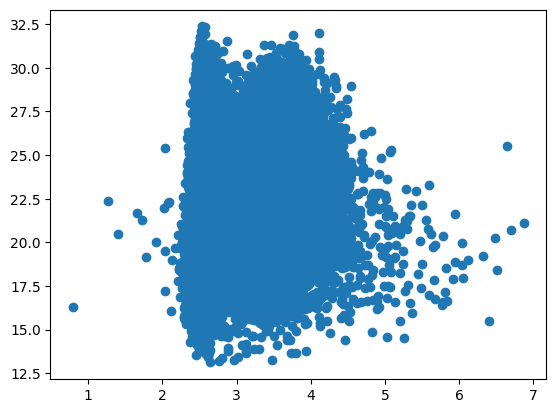

In [ ]:
plt.scatter(x='RightwardCropOfTheFaceImage', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('RightwardCropOfTheFaceImage > 5 or RightwardCropOfTheFaceImage < 2')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

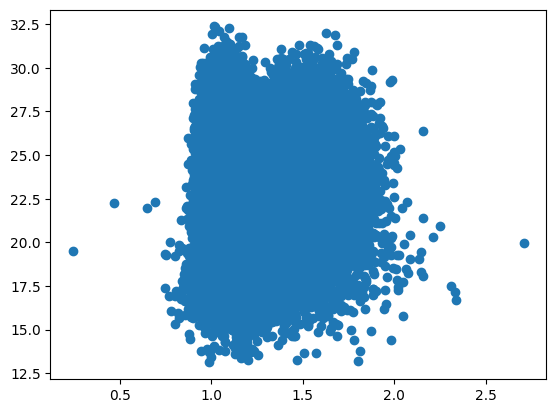

In [ ]:
plt.scatter(x='MarginAboveOfTheFaceImage', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('MarginAboveOfTheFaceImage > 2.0 or MarginAboveOfTheFaceImage < 0.75')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

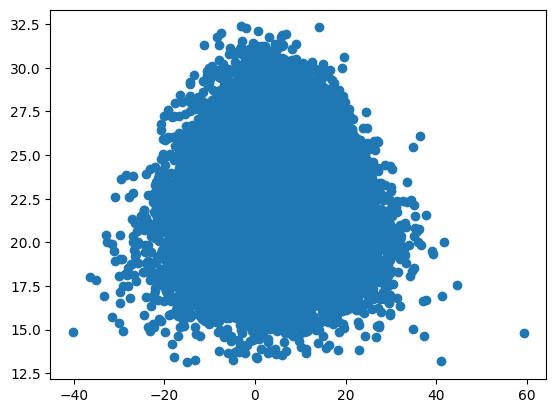

In [ ]:
plt.scatter(x='HeadPosePitch', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('HeadPosePitch > 38 or HeadPosePitch < -32')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

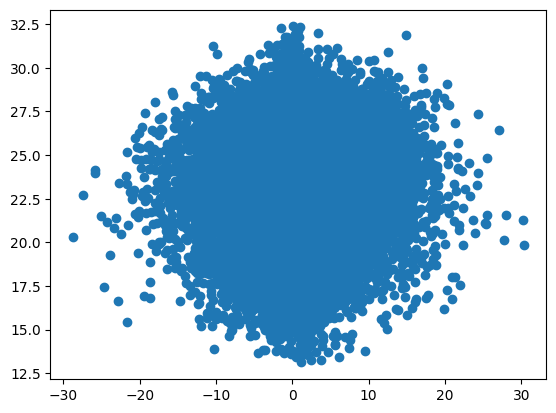

In [ ]:
plt.scatter(x='HeadPoseRoll', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('HeadPoseRoll > 25 or HeadPoseRoll < -23')
full_dataset_df = full_dataset_df[full_dataset_df.index.isin(to_remove.index) == False]

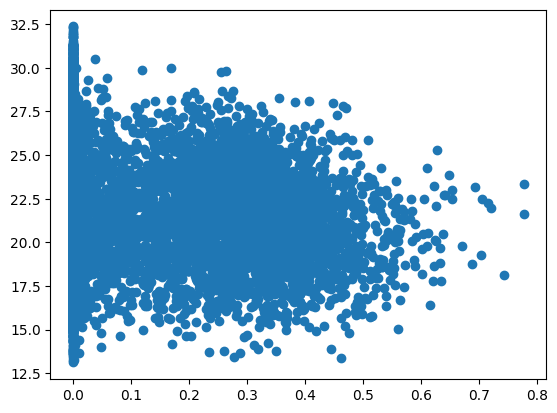

In [ ]:
plt.scatter(x='NoHeadCoverings', y='UnifiedQualityScore', data=full_dataset_df)
to_remove = full_dataset_df.query('NoHeadCoverings > 0.0')


In [ ]:
to_remove

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,...,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
2,C://Users//admin//Downloads//lfw//flat_lfw/Aar...,17.987562,64.520862,0.459137,0.243947,0.013221,0.110664,0.000000,6.794354,-34,...,100,100,93,80,96,100,87,98,2,NaN
11,C://Users//admin//Downloads//lfw//flat_lfw/Abb...,21.176453,34.409306,0.347107,0.188585,0.008847,0.054985,0.000292,6.458166,49,...,100,100,86,71,93,97,100,92,100,NaN
13,C://Users//admin//Downloads//lfw//flat_lfw/Abd...,19.427111,187.851509,0.506939,0.154711,0.010546,0.320706,0.000000,6.343090,35,...,100,100,90,73,87,100,100,42,5,NaN
59,C://Users//admin//Downloads//lfw//flat_lfw/Abi...,20.982929,95.567391,0.550964,0.118109,0.009254,0.473144,0.000000,6.237744,19,...,100,100,92,66,99,100,100,31,80,NaN
60,C://Users//admin//Downloads//lfw//flat_lfw/Abi...,19.047457,2.122254,0.507804,0.337729,0.062064,0.205436,0.000000,7.618697,-10,...,100,100,40,18,86,99,90,68,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33203,C://Users//admin//Desktop//Flickr-10000/19970.png,23.995432,44.641841,0.687500,0.227527,0.021921,0.164453,0.000018,7.069655,49,...,100,100,6,0,100,100,100,24,47,NaN
33214,C://Users//admin//Desktop//Flickr-10000/19981.png,22.450264,228.788538,0.035918,0.184828,0.038557,0.475200,0.000203,6.859678,47,...,100,100,32,3,99,75,100,74,80,NaN
33217,C://Users//admin//Desktop//Flickr-10000/19984.png,19.829638,166.259163,0.355469,0.162764,0.008873,0.216803,0.000000,6.402817,-29,...,100,100,4,0,92,99,100,31,4,NaN
33218,C://Users//admin//Desktop//Flickr-10000/19985.png,21.662836,142.721059,0.194637,0.323294,0.072344,0.218198,0.000000,7.401826,-34,...,100,100,2,0,100,80,100,11,4,NaN


In [1412]:
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\LFW_scores.csv')
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-0to9999.csv')
full_dataset_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\combined_files.csv')
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-only.csv')


In [1413]:
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['UnifiedQualityScore.scalar'] < 100 ) & (full_dataset_df['BackgroundUniformity.scalar'] < 100) & (full_dataset_df['IlluminationUniformity.scalar'] < 100) & (full_dataset_df['LuminanceMean.scalar'] < 100) & (full_dataset_df['LuminanceVariance.scalar'] < 100)]
print(len(full_dataset_df.index))

# train_df = train_df[(train_df['UnderExposurePrevention.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['OverExposurePrevention.scalar'] < 100 )]
# print(len(train_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['DynamicRange.scalar'] < 100 )]
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['Sharpness.scalar'] < 100 )]
print(len(full_dataset_df.index))

# train_df = train_df[(train_df['CompressionArtifacts.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['NaturalColour.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['UnderExposurePrevention.scalar'] < 100 ) & (train_df['OverExposurePrevention.scalar'] < 100 ) & (train_df['DynamicRange.scalar'] < 100 ) & (train_df['Sharpness.scalar'] < 100 ) & (train_df['CompressionArtifacts.scalar'] < 100 ) & (train_df['NaturalColour.scalar'] < 100 )]
# print(len(train_df.index))




# train_df = train_df[(train_df['SingleFacePresent.scalar'] < 100 )]
# print(len(train_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['EyesOpen.scalar'] < 100 )]
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['MouthClosed.scalar'] < 100 )]
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['EyesVisible.scalar'] < 100 )]
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['MouthOcclusionPrevention.scalar'] < 100 )]
print(len(full_dataset_df.index))


full_dataset_df = full_dataset_df[(full_dataset_df['FaceOcclusionPrevention.scalar'] < 100)]
print(len(full_dataset_df.index))


# train_df = train_df[(train_df['SingleFacePresent.scalar'] < 100 ) & (train_df['EyesOpen.scalar'] < 100 ) & (train_df['MouthClosed.scalar'] < 100 ) & (train_df['EyesVisible.scalar'] < 100 ) & (train_df['MouthOcclusionPrevention.scalar'] < 100 ) & (train_df['FaceOcclusionPrevention.scalar'] < 100)]
# print(len(train_df.index))






full_dataset_df = full_dataset_df[(full_dataset_df['InterEyeDistance.scalar'] < 100 ) & (full_dataset_df['HeadSize.scalar'] < 100 ) & (full_dataset_df['LeftwardCropOfTheFaceImage.scalar'] < 100 ) & (full_dataset_df['RightwardCropOfTheFaceImage.scalar'] < 100 ) & (full_dataset_df['MarginAboveOfTheFaceImage.scalar'] < 100)]
print(len(full_dataset_df.index))




full_dataset_df = full_dataset_df[(full_dataset_df['MarginBelowOfTheFaceImage.scalar'] < 100 )]
print(len(full_dataset_df.index))


full_dataset_df = full_dataset_df[(full_dataset_df['HeadPoseYaw.scalar'] < 100 )]
print(len(full_dataset_df.index))


full_dataset_df = full_dataset_df[(full_dataset_df['HeadPosePitch.scalar'] < 100 )]
print(len(full_dataset_df.index))


full_dataset_df = full_dataset_df[(full_dataset_df['HeadPoseRoll.scalar'] < 100 )]
print(len(full_dataset_df.index))



full_dataset_df = full_dataset_df[(full_dataset_df['ExpressionNeutrality.scalar'] < 100 )]
print(len(full_dataset_df.index))

full_dataset_df = full_dataset_df[(full_dataset_df['NoHeadCoverings.scalar'] < 100)]
print(len(full_dataset_df.index))

# train_df = train_df[(train_df['MarginBelowOfTheFaceImage.scalar'] < 100 ) & (train_df['HeadPoseYaw.scalar'] < 100 ) & (train_df['HeadPosePitch.scalar'] < 100 ) & (train_df['HeadPoseRoll.scalar'] < 100 ) & (train_df['ExpressionNeutrality.scalar'] < 100 ) & (train_df['NoHeadCoverings.scalar'] < 100)]
# print(len(train_df.index))
       

# More than half of all photos have MarginBelowOfTheFaceImage <= 0...

58233
49731
49731
37470
16051
16051
4716
320
320
0
0
0
0
0
0
0
